In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

# **DATA**

In [29]:
new_market = pd.read_csv('./new_market.csv')
new_market['pricingDate'] = pd.to_datetime(new_market['pricingDate'])
# 2018.05.01 ~ 2023.04.30 기간 데이터 필터링
filtered_data = new_market[(new_market['pricingDate'] >= '2018-05-01') & (new_market['pricingDate'] <= '2023-04-30')]

In [30]:
ticker_15 = ['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE',
             'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']

ticker_30 = ['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 
             'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 
             'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']

ticker_45 = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 
             'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 
             'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 
             'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 
             'META', 'HD', 'VZ', 'MRK']

a = ['pricingDate'] + ticker_15
b = ['pricingDate'] + ticker_30
c = ['pricingDate'] + ticker_45
 
ticker_15_price = filtered_data[a]
ticker_30_price = filtered_data[b]
ticker_45_price = filtered_data[c]

In [31]:
ticker_15_price.to_csv('./ticker_15_price.csv')
ticker_30_price.to_csv('./ticker_30_price.csv')
ticker_45_price.to_csv('./ticker_45_price.csv')

# **Scenario**

In [32]:
# 2018.05.01 ~ 2023.04.30 기간에서 30일씩 3번에 걸쳐서 랜덤하게 선택되는 시나리오를 1000개 만들기

# 각 시나리오 부분별로 필요한 일수
days_per_part = 30

num_scenarios = 1000
total_days = ticker_15_price.shape[0]

scenarios = []

# 각 시나리오를 3개의 랜덤한 30일로 구성

for _ in range(num_scenarios):
   
    scenario_data = pd.DataFrame()

    # 사용된 일자를 추적하기 위한 집합
    used_days = set()

    for _ in range(3):
        # 중복되지 않는 30일 기간을 선택
        while True:
            start_day = np.random.randint(0, total_days - days_per_part)
            end_day = start_day + days_per_part

            # 선택된 기간이 이전에 사용된 일자와 중복되지 않는지 확인
            if not used_days.intersection(set(range(start_day, end_day))):
                break

        # 사용된 일자 업데이트
        used_days.update(range(start_day, end_day))

        # 데이터셋에서 30일 기간의 데이터 추출
        part_data = ticker_15_price.iloc[start_day:end_day]

        # 추출된 30일 데이터를 시나리오 데이터에 추가
        scenario_data = pd.concat([scenario_data, part_data])

    # 완성된 시나리오 데이터를 시나리오 목록에 추가
    scenarios.append(scenario_data)


scenarios[0]

,pricingDate,AAPL,AMZN,NVDA,JPM,PG,PFE,JNJ,KO,XOM,NEE,GOOGL,MSFT,TSLA,NKE,BAC
282,2019-06-14,46.687129,93.4835,35.960262,95.859937,100.081188,34.507424,125.004650,44.978499,59.415627,47.208479,54.3150,127.036235,14.328000,79.981629,25.288640
283,2019-06-17,46.965691,94.3015,36.057223,95.336208,99.892185,34.604264,124.424644,44.592794,60.006986,47.073897,54.6945,127.419885,15.002000,78.706754,25.189434
284,2019-06-18,48.070253,95.0685,38.008883,96.636802,98.641171,34.757594,125.129575,44.391175,60.526423,46.857198,55.2620,129.635466,14.982666,80.805984,25.811729
285,2019-06-19,47.929761,95.4395,38.068551,95.938497,99.379179,35.104605,125.325884,44.811944,60.190787,47.044243,55.2255,130.143803,15.095333,80.087070,25.541166
286,2019-06-20,48.314904,95.9095,38.312198,96.182904,100.567193,35.185306,126.896362,45.285310,61.221670,47.076178,55.6600,131.352302,14.641333,81.707024,25.496072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2022-01-18,168.103007,158.9175,258.695963,143.250469,150.087963,50.809229,159.292223,57.797542,68.592405,77.999719,135.9980,297.808522,343.503333,144.015892,44.192216
937,2022-01-19,164.568686,156.2990,250.346744,141.034524,155.134627,50.274000,158.796520,57.892448,68.620562,79.286115,135.1165,298.477644,331.883333,142.212631,44.364170
938,2022-01-20,162.865876,151.6675,241.188569,139.831852,155.972062,50.752889,157.528664,57.655183,68.770737,80.169311,133.3075,296.775319,332.090000,139.880151,43.705012
939,2022-01-21,160.786863,142.6430,233.438576,137.388630,156.568992,49.569751,157.166420,57.370466,67.738285,79.295714,130.3515,291.294422,314.633333,140.095759,42.912113


In [33]:
# 시나리오가 랜덤하게 잘 구성되었는지 확인

scenario0 = scenarios[0]
scenario1 = scenarios[1]
scenario2 = scenarios[2]
scenario3 = scenarios[3]

In [34]:
#시나리오 주간 기대수익률, 표준편차 계산

# 각 시나리오에 대해 가중치가 적용된 수익률을 계산하는 함수
def calculate_weighted_returns(scenario, weights):
   
    # 날짜(비수치데이터) 제거
    scenario_numeric = scenario.select_dtypes(include=[np.number])

    # 가중치가 적용된 수익률 계산
    weighted_returns = scenario_numeric.multiply(weights) 
    total_returns = weighted_returns.sum(axis=1)
    return total_returns

#각 시나리오에 대한 주간 수익률 통계를 계산하는 함수
def calculate_daily_statistics(scenarios, weights):
    daily_stats = []

    for scenario in scenarios:
        # 총 가중치가 적용된 수익률 계산
        total_returns = calculate_weighted_returns(scenario, weights)

        # 일별 수익률 계산
        daily_returns = total_returns.pct_change().dropna()  # pct_change() 함수는 기본적으로 1일 간격으로 수익률을 계산

        # 통계 계산
        mean_return = daily_returns.mean()
        std_deviation = daily_returns.std()

        daily_stats.append((mean_return, std_deviation))

    return daily_stats

# **GPT-weighted Portfolio simulation**

In [35]:
gpt_weighted_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

gpt_weighted_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

gpt_weighted_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [36]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_gpt_15 = pd.Series(gpt_weighted_15) 
daily_statistics_gpt_15 = calculate_daily_statistics(scenarios, weights_series_gpt_15) 

weights_series_gpt_30 = pd.Series(gpt_weighted_30)
daily_statistics_gpt_30 = calculate_daily_statistics(scenarios, weights_series_gpt_30)

weights_series_gpt_45 = pd.Series(gpt_weighted_45)
daily_statistics_gpt_45 = calculate_daily_statistics(scenarios, weights_series_gpt_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_gpt_15[0]

(0.012091885791806891, 0.08807811907574553)

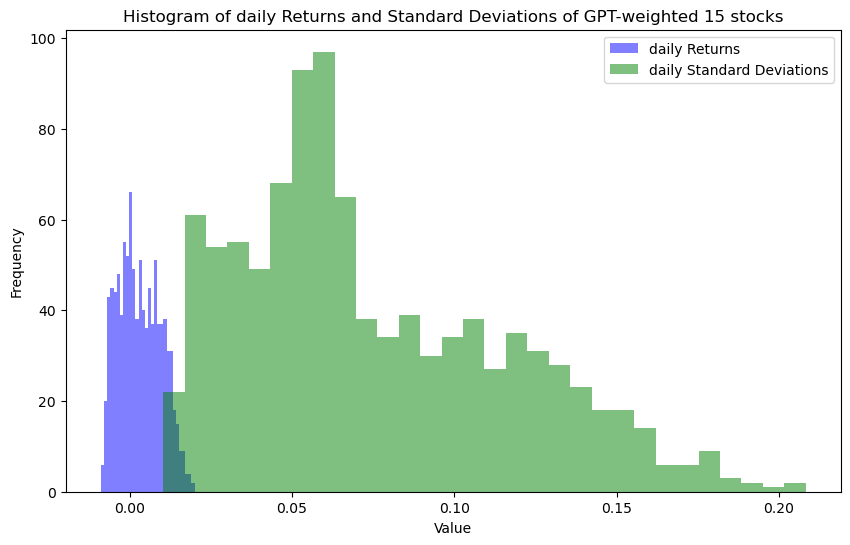

In [37]:
# GPT-weighted 15 stocks의 주간 수익률과 표준편차 히스토그램

# 누적수익률도 그리기 (3개월동안 전체 수익률)

returns_15, std_devs_15 = zip(*daily_statistics_gpt_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

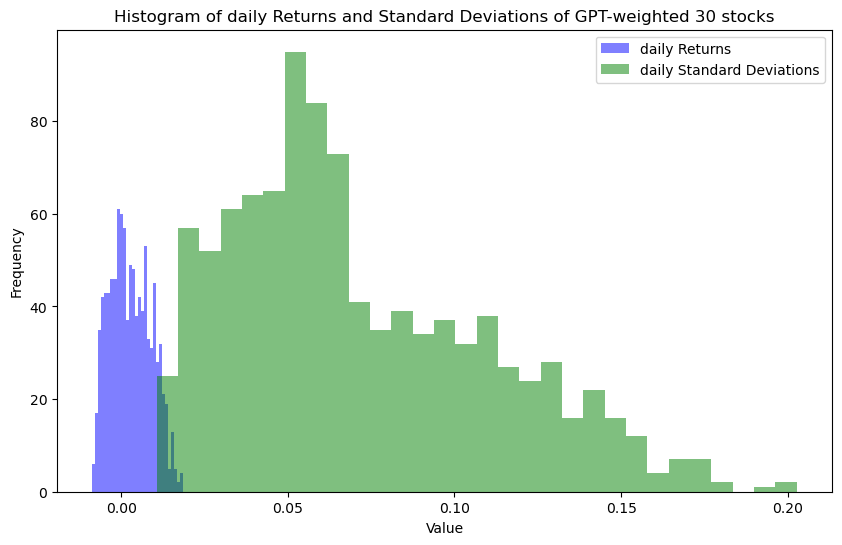

In [38]:
#GPT-weighted 30 stocks의 주간 수익률과 표준편차 히스토그램

returns_30, std_devs_30 = zip(*daily_statistics_gpt_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

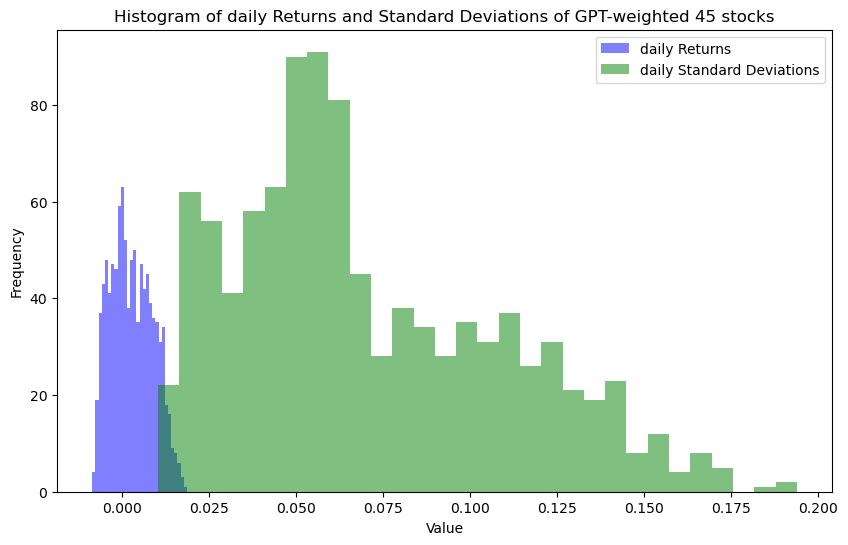

In [39]:
#GPT-weighted 45 stocks의 주간 수익률과 표준편차 히스토그램

returns_45, std_devs_45 = zip(*daily_statistics_gpt_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **GPT-Equal Portfolio simulation**

In [43]:
gpt_equal_15 = {
    "AAPL": 0.06666666666666667,
    "AMZN": 0.06666666666666667,
    "NVDA": 0.06666666666666667,
    "JPM": 0.06666666666666667,
    "PG": 0.06666666666666667,
    "PFE": 0.06666666666666667,
    "JNJ": 0.06666666666666667,
    "KO": 0.06666666666666667,
    "XOM": 0.06666666666666667,
    "NEE": 0.06666666666666667,
    "GOOGL": 0.06666666666666667,
    "MSFT": 0.06666666666666667,
    "TSLA": 0.06666666666666667,
    "NKE": 0.06666666666666667,
    "BAC": 0.06666666666666667
}

gpt_equal_30 = {
    "MSFT": 0.03333333333333333,
    "AMZN": 0.03333333333333333,
    "NVDA": 0.03333333333333333,
    "AAPL": 0.03333333333333333,
    "GOOGL": 0.03333333333333333,
    "ADBE": 0.03333333333333333,
    "JNJ": 0.03333333333333333,
    "PFE": 0.03333333333333333,
    "MRK": 0.03333333333333333,
    "ABT": 0.03333333333333333,
    "PG": 0.03333333333333333,
    "KO": 0.03333333333333333,
    "JPM": 0.03333333333333333,
    "GS": 0.03333333333333333,
    "CAT": 0.03333333333333333,
    "CVX": 0.03333333333333333,
    "XOM": 0.03333333333333333,
    "BA": 0.03333333333333333,
    "TSLA": 0.03333333333333333,
    "NEE": 0.03333333333333333,
    "NKE": 0.03333333333333333,
    "VZ": 0.03333333333333333,
    "CRM": 0.03333333333333333,
    "UNH": 0.03333333333333333,
    "WMT": 0.03333333333333333,
    "QCOM": 0.03333333333333333,
    "BAC": 0.03333333333333333,
    "V": 0.03333333333333333,
    "MCD": 0.03333333333333333,
    "INTC": 0.03333333333333333
}

gpt_equal_45 = {
    "AAPL": 0.022222,
    "GOOGL": 0.022222,
    "MSFT": 0.022222,
    "NVDA": 0.022222,
    "AMD": 0.022222,
    "ORCL": 0.022222,
    "CRM": 0.022222,
    "INTC": 0.022222,
    "CSCO": 0.022222,
    "JPM": 0.022222,
    "GS": 0.022222,
    "BAC": 0.022222,
    "MS": 0.022222,
    "AXP": 0.022222,
    "C": 0.022222,
    "JNJ": 0.022222,
    "UNH": 0.022222,
    "PFE": 0.022222,
    "ABBV": 0.022222,
    "TSLA": 0.022222,
    "AMGN": 0.022222,
    "GILD": 0.022222,
    "PG": 0.022222,
    "KO": 0.022222,
    "NKE": 0.022222,
    "PEP": 0.022222,
    "COST": 0.022222,
    "WMT": 0.022222,
    "TGT": 0.022222,
    "XOM": 0.022222,
    "CVX": 0.022222,
    "NEE": 0.022222,
    "DUK": 0.022222,
    "SO": 0.022222,
    "SLB": 0.022222,
    "MMM": 0.022222,
    "CAT": 0.022222,
    "HON": 0.022222,
    "GE": 0.022222,
    "ADP": 0.022222,
    "AMZN": 0.022222,
    "META": 0.022222,
    "HD": 0.022222,
    "VZ": 0.022222,
    "MRK": 0.022222,

}

In [44]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_gpt_equal_15 = pd.Series(gpt_equal_15) 
daily_statistics_gpt_equal_15 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_15) 

weights_series_gpt_equal_30 = pd.Series(gpt_equal_30)
daily_statistics_gpt_equal_30 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_30)

weights_series_gpt_equal_45 = pd.Series(gpt_equal_45)
daily_statistics_gpt_equal_45 = calculate_daily_statistics(scenarios, weights_series_gpt_equal_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_gpt_equal_15[0]

(0.011382734949725958, 0.08352668116686864)

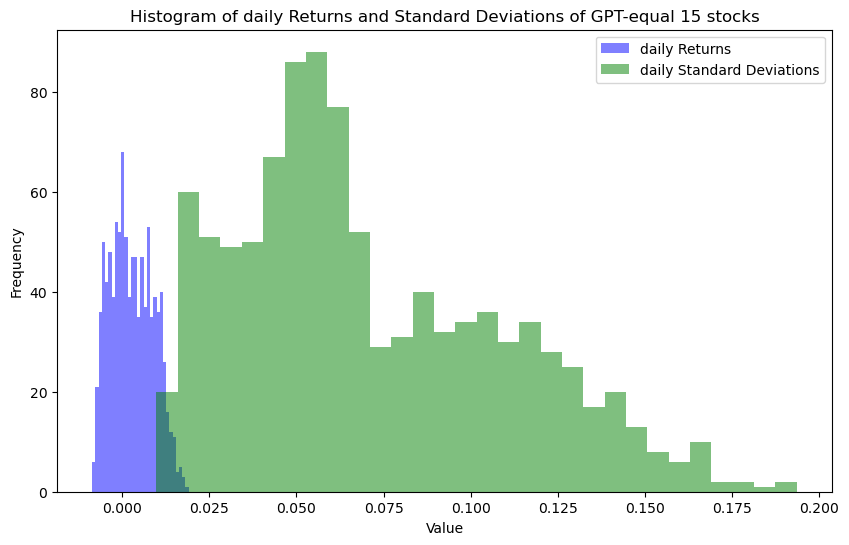

In [45]:
#GPT-equal 15 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_15, std_devs_equal_15 = zip(*daily_statistics_gpt_equal_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

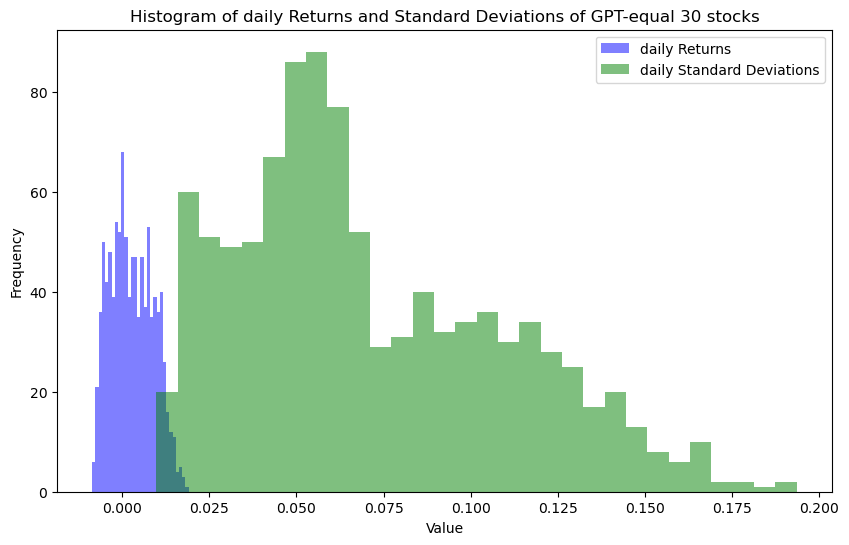

In [46]:
#GPT-equal 30 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_30, std_devs_equal_30 = zip(*daily_statistics_gpt_equal_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

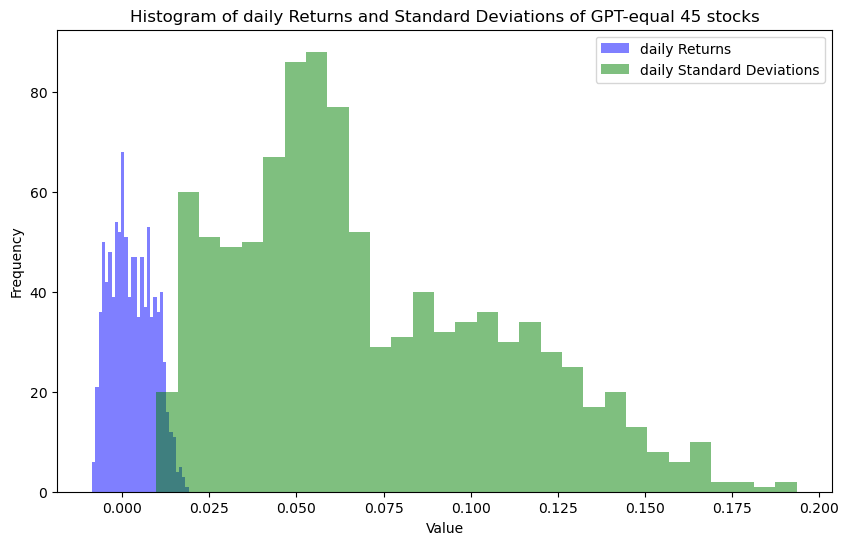

In [47]:
#GPT-equal 45 stocks의 주간 수익률과 표준편차 히스토그램

returns_equal_45, std_devs_equal_45 = zip(*daily_statistics_gpt_equal_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_equal_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_equal_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GPT-equal 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **Mean-Variance Optimization**

# **EPO**

## GMV

In [49]:
epo_GMV_weighted_15 = {'AAPL': 0.04575246928786821, 'AMZN': 0.07265377471492239, 'NVDA': 0.06481175209487042, 'JPM': 0.05609762627137712, 'PG': 0.0719435734229653, 'PFE': 0.08771670571734723, 'JNJ': 0.07277777173189208, 'KO': 0.06312539328973277, 'XOM': 0.08609507668538831, 'NEE': 0.07221233969635621, 'GOOGL': 0.05010272070811802, 'MSFT': 0.03828500762569085, 'TSLA': 0.10055629310834088, 'NKE': 0.06129593107749074, 'BAC': 0.05657356456763967}

epo_GMV_weighted_30 = {'MSFT': 0.01666666774419816, 'AMZN': 0.042227409477106695, 'NVDA': 0.03118097512246346, 'AAPL': 0.01666667168358331, 'GOOGL': 0.01809943946174481, 'ADBE': 0.02570202818687248, 'JNJ': 0.035080295142533816, 'PFE': 0.052582684453145526, 'MRK': 0.0475986044981093, 'ABT': 0.022988231711774245, 'PG': 0.03608309079046335, 'KO': 0.027444963001599185, 'JPM': 0.01940313030454212, 'GS': 0.017845787304226788, 'CAT': 0.0336990887241052, 'CVX': 0.03478235727173764, 'XOM': 0.044706637080323186, 'BA': 0.0401698232395637, 'TSLA': 0.06666666228078902, 'NEE': 0.03819709421977127, 'NKE': 0.0283698072324536, 'VZ': 0.05348428364961278, 'CRM': 0.03498396614637049, 'UNH': 0.028482865710042066, 'WMT': 0.05711849959966492, 'QCOM': 0.03681044243477318, 'BAC': 0.020125552595200585, 'V': 0.01666666803231992, 'MCD': 0.02878298920491861, 'INTC': 0.027383283695990274}

epo_GMV_weighted_45 = {'AAPL': 0.011111111751157617, 'GOOGL': 0.01111111297691952, 'MSFT': 0.011111111430617887, 'NVDA': 0.020599077895606076, 'AMD': 0.03653237143698704, 'ORCL': 0.015218203234319534, 'CRM': 0.025585621866165295, 'INTC': 0.0148918676649769, 'CSCO': 0.011111111697909464, 'JPM': 0.011111111820343578, 'GS': 0.011111111721518976, 'BAC': 0.011111111767753831, 'MS': 0.011111111469553583, 'AXP': 0.011111112963466332, 'C': 0.011111112282785603, 'JNJ': 0.01964611725182824, 'UNH': 0.015656892605666366, 'PFE': 0.035078102280757445, 'ABBV': 0.03551029346356419, 'TSLA': 0.044444444168593604, 'AMGN': 0.02325584568021071, 'GILD': 0.04291396596857637, 'PG': 0.0206357790550594, 'KO': 0.013316299685923442, 'NKE': 0.01674069301271715, 'PEP': 0.011111111949044126, 'COST': 0.01826983490242041, 'WMT': 0.04056916285774872, 'TGT': 0.037234796445756904, 'XOM': 0.027932252543989945, 'CVX': 0.01919461191506784, 'NEE': 0.024679849836699883, 'DUK': 0.024462591103417974, 'SO': 0.023809199341675347, 'SLB': 0.04092564530241869, 'MMM': 0.01548505448035055, 'CAT': 0.017262973373497175, 'HON': 0.011111111477449984, 'GE': 0.035796179555666094, 'ADP': 0.011111111372353847, 'AMZN': 0.03089377368024163, 'META': 0.03873632462625635, 'HD': 0.0111111116930388, 'VZ': 0.03677614040679746, 'MRK': 0.03239046798313052}

In [50]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_GMV_15 = pd.Series(epo_GMV_weighted_15)
daily_statistics_epo_GMV_15 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_15)

weights_series_epo_GMV_30 = pd.Series(epo_GMV_weighted_30)
daily_statistics_epo_GMV_30 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_30)

weights_series_epo_GMV_45 = pd.Series(epo_GMV_weighted_45)
daily_statistics_epo_GMV_45 = calculate_daily_statistics(scenarios, weights_series_epo_GMV_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_GMV_15[0]

(0.011988144160648561, 0.08678810446525712)

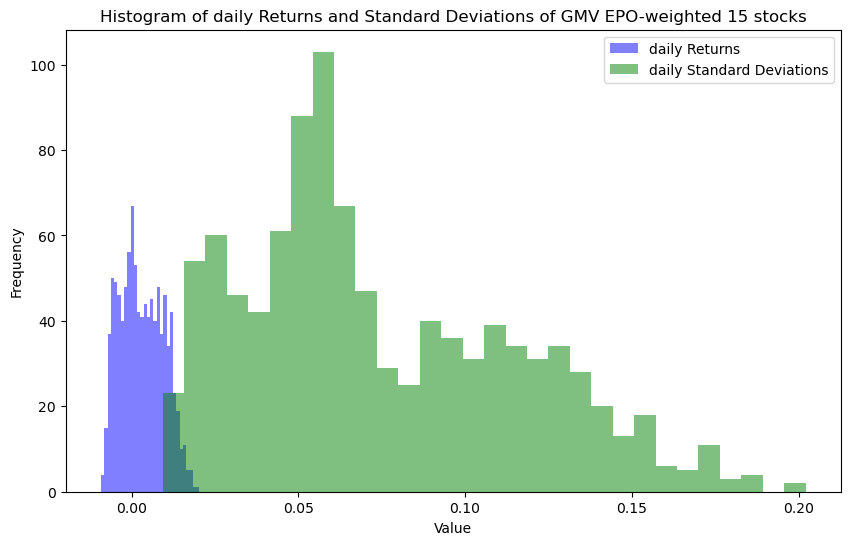

In [51]:
#epo_GMV_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_15, std_devs_epo_GMV_15 = zip(*daily_statistics_epo_GMV_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

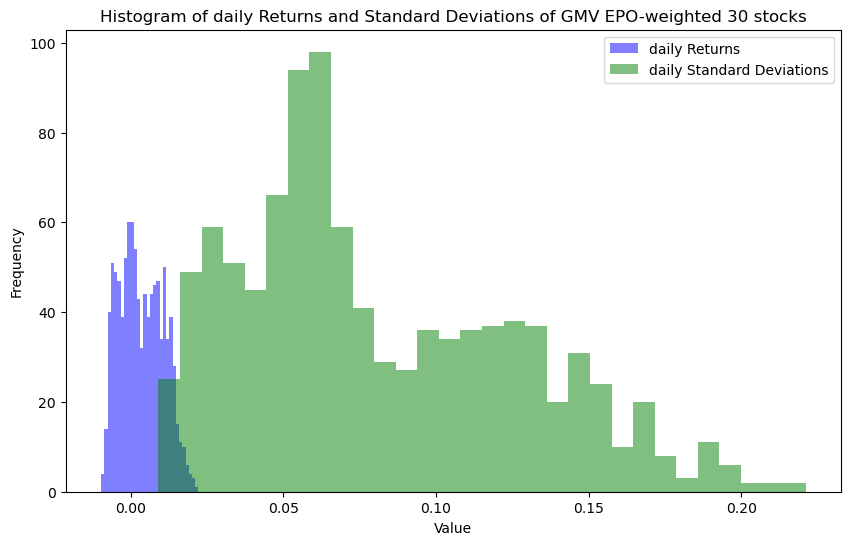

In [57]:
#epo_GMV_weighted_30의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_30, std_devs_epo_GMV_30 = zip(*daily_statistics_epo_GMV_30)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_30, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_30, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 30 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

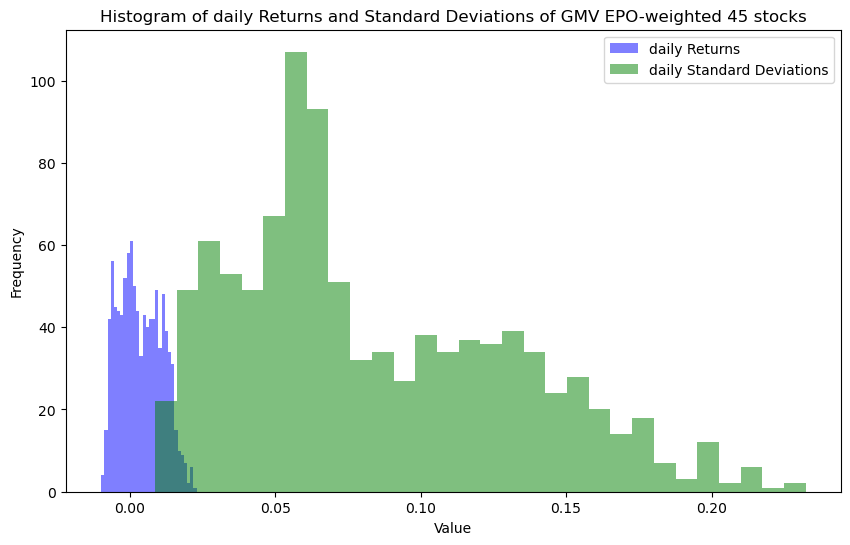

In [58]:
#epo_GMV_weighted_45의 주간 수익률과 표준편차 히스토그램

returns_epo_GMV_45, std_devs_epo_GMV_45 = zip(*daily_statistics_epo_GMV_45)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_GMV_45, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_GMV_45, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of GMV EPO-weighted 45 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Return

In [25]:
epo_Maxret_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.13333, 'JPM': 0.03333, 'PG': 0.13333, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03333, 'XOM': 0.03333, 'NEE': 0.03333, 'GOOGL': 0.03333, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03333, 'BAC': 0.03333}

epo_Maxret_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.06667, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.06667, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.06667, 'TSLA': 0.01667, 'NEE': 0.01667, 'NKE': 0.01667, 'VZ': 0.06667, 'CRM': 0.01667, 'UNH': 0.06667, 'WMT': 0.01667, 'QCOM': 0.01667, 'BAC': 0.01667, 'V': 0.01667, 'MCD': 0.01667, 'INTC': 0.01667}

epo_Maxret_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.04444, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.04444, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.04444, 'UNH': 0.01111, 'PFE': 0.01111, 'ABBV': 0.04444, 'TSLA': 0.01111, 'AMGN': 0.01111, 'GILD': 0.04444, 'PG': 0.01111, 'KO': 0.031, 'NKE': 0.029, 'PEP': 0.04444, 'COST': 0.037, 'WMT': 0.04444, 'TGT': 0.016, 'XOM': 0.01111, 'CVX': 0.043, 'NEE': 0.01111, 'DUK': 0.01111, 'SO': 0.01111, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.01111, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.04444, 'MRK': 0.04444}

In [52]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_Maxret_15 = pd.Series(epo_Maxret_weighted_15)
daily_statistics_epo_Maxret_15 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_15)

weights_series_epo_Maxret_30 = pd.Series(epo_Maxret_weighted_30)
daily_statistics_epo_Maxret_30 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_30)

weights_series_epo_Maxret_45 = pd.Series(epo_Maxret_weighted_45)
daily_statistics_epo_Maxret_45 = calculate_daily_statistics(scenarios, weights_series_epo_Maxret_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_Maxret_15[0]

(0.016150669671088164, 0.1117764493446473)

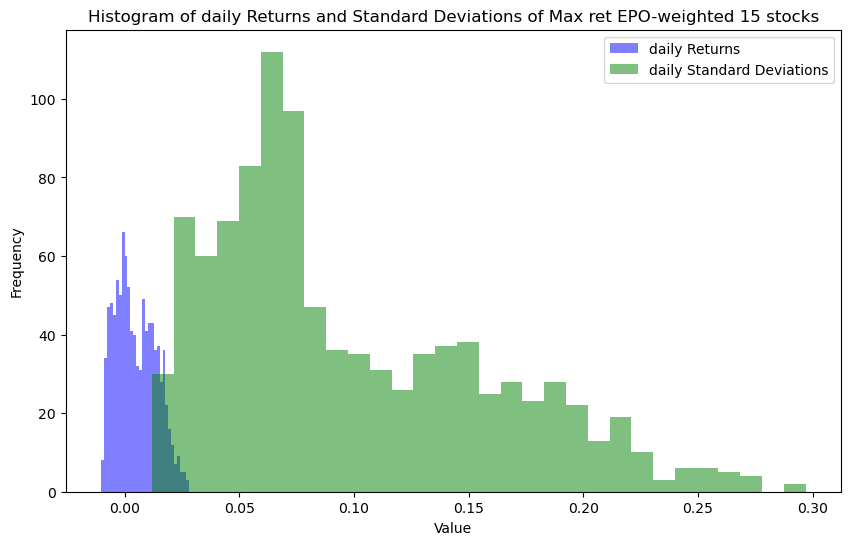

In [53]:
#epo_Maxret_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_Maxret_15, std_devs_epo_Maxret_15 = zip(*daily_statistics_epo_Maxret_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_Maxret_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_Maxret_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max ret EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Max Sharpe

In [54]:
epo_MaxSharpe_weighted_15 = {'AAPL': 0.13333, 'AMZN': 0.03333, 'NVDA': 0.13333, 'JPM': 0.03333, 'PG': 0.09539, 'PFE': 0.03333, 'JNJ': 0.03333, 'KO': 0.03333, 'XOM': 0.03707, 'NEE': 0.05699, 'GOOGL': 0.03897, 'MSFT': 0.13333, 'TSLA': 0.13333, 'NKE': 0.03825, 'BAC': 0.03333}

epo_MaxSharpe_weighted_30 = {'MSFT': 0.06667, 'AMZN': 0.01667, 'NVDA': 0.06667, 'AAPL': 0.06667, 'GOOGL': 0.0387, 'ADBE': 0.01667, 'JNJ': 0.01667, 'PFE': 0.01667, 'MRK': 0.06667, 'ABT': 0.02469, 'PG': 0.06667, 'KO': 0.01667, 'JPM': 0.01667, 'GS': 0.01667, 'CAT': 0.01667, 'CVX': 0.01667, 'XOM': 0.01667, 'BA': 0.06667, 'TSLA': 0.0443, 'NEE': 0.02974, 'NKE': 0.01667, 'VZ': 0.01667, 'CRM': 0.05967, 'UNH': 0.04331, 'WMT': 0.06667, 'QCOM': 0.01667, 'BAC': 0.01667, 'V': 0.02625, 'MCD': 0.01667, 'INTC': 0.01667}

epo_MaxSharpe_weighted_45 = {'AAPL': 0.04444, 'GOOGL': 0.04379, 'MSFT': 0.04444, 'NVDA': 0.04444, 'AMD': 0.04444, 'ORCL': 0.04444, 'CRM': 0.01111, 'INTC': 0.01111, 'CSCO': 0.01111, 'JPM': 0.01111, 'GS': 0.01111, 'BAC': 0.01111, 'MS': 0.01111, 'AXP': 0.01111, 'C': 0.01111, 'JNJ': 0.04444, 'UNH': 0.01111, 'PFE': 0.01111, 'ABBV': 0.04444, 'TSLA': 0.01111, 'AMGN': 0.01111, 'GILD': 0.04444, 'PG': 0.01111, 'KO': 0.0312, 'NKE': 0.02923, 'PEP': 0.04444, 'COST': 0.03726, 'WMT': 0.04444, 'TGT': 0.01557, 'XOM': 0.01111, 'CVX': 0.04296, 'NEE': 0.01111, 'DUK': 0.01111, 'SO': 0.01111, 'SLB': 0.01111, 'MMM': 0.01111, 'CAT': 0.01111, 'HON': 0.01111, 'GE': 0.01111, 'ADP': 0.01111, 'AMZN': 0.01111, 'META': 0.01111, 'HD': 0.01111, 'VZ': 0.04444, 'MRK': 0.04444}

In [55]:
# 시나리오 분석 수행 각각의 가중치 시리즈만 넣어서 만들면 됨
weights_series_epo_MaxSharpe_15 = pd.Series(epo_MaxSharpe_weighted_15)
daily_statistics_epo_MaxSharpe_15 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_15)

weights_series_epo_MaxSharpe_30 = pd.Series(epo_MaxSharpe_weighted_30)
daily_statistics_epo_MaxSharpe_30 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_30)

weights_series_epo_MaxSharpe_45 = pd.Series(epo_MaxSharpe_weighted_45)
daily_statistics_epo_MaxSharpe_45 = calculate_daily_statistics(scenarios, weights_series_epo_MaxSharpe_45)

# 첫 번째 시나리오의 통계를 예시로 표시
daily_statistics_epo_MaxSharpe_15[0]

(0.016480103329467925, 0.11427926010141881)

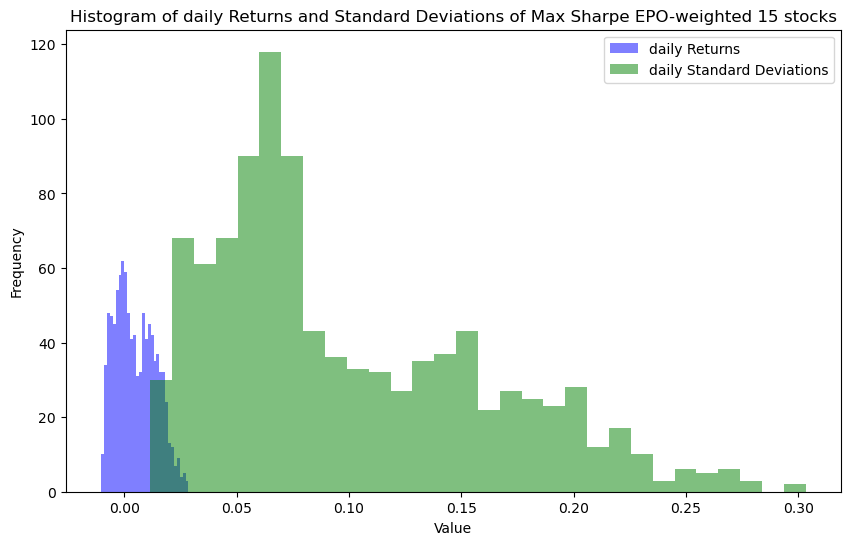

In [56]:
#epo_MaxSharpe_weighted_15의 주간 수익률과 표준편차 히스토그램

returns_epo_MaxSharpe_15, std_devs_epo_MaxSharpe_15 = zip(*daily_statistics_epo_MaxSharpe_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_epo_MaxSharpe_15, bins=30, alpha=0.5, label='daily Returns', color='blue')
plt.hist(std_devs_epo_MaxSharpe_15, bins=30, alpha=0.5, label='daily Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of daily Returns and Standard Deviations of Max Sharpe EPO-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()